In [1]:
import numpy as np
import glob
import os
import importlib
import yaml
import albumentations
import glob
import json
import torch
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from omegaconf import OmegaConf
from tqdm.notebook import tqdm
from taming.modules.util import box_mask, BatchRandomMask
from taming.modules.losses.lpips import LPIPS
from skimage.transform import rescale, resize, downscale_local_mean
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

def imshow(images, titles=None, save_path=None):
    n_img = len(images)
    plt.rcParams['figure.figsize'] = [4*n_img, 4*n_img]
    
    if n_img > 1:
        fig, ax = plt.subplots(1, n_img)
        for i in range(n_img):
            if titles is not None and i < len(titles):
                ax[i].set_title(titles[i])
            ax[i].axis('off')
            ax[i].imshow(images[i])
    else:
        if titles is not None:
            plt.set_titile(titles[0])
        plt.axis('off')
        plt.imshow(images[0])

    if save_path is not None:
        plt.savefig(save_path)

def center_crop(image, s=512):
    h, w = image.shape[:2]
    if s > h or s > w:
        image = rescale(image, s/min(h,w), anti_aliasing=True)
        image = (image * 255).astype(np.uint8)
        h, w = image.shape[:2]
    ih = (h - s) // 2   
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

# load a single input
def preprocess(x, res=512, normalize=True):
    if normalize:
        x = x.transpose(2,0,1)
        x = (torch.from_numpy(x).float().to(device) / 127.5 - 1).unsqueeze(0)
    else:
        x = torch.from_numpy(x).float().to(device).unsqueeze(0)
    return torch.nn.functional.interpolate(x, size=(res,res))
    
def to_img(x):
    x = (x.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    return x[0].detach().cpu().numpy()

def readmask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    return mask

# validation input
# places_val_files = glob.glob("/home/ICT2000/chenh/Haiwei/Datasets/Places365/val_large/*.jpg")
places_val_files = glob.glob("/home/chenh/data/val_large/*.jpg")

# images = [center_crop(imread(f)) for f in places_val_files[k:k+3]]
# imshow(images)

# validation results (MAT)
places_val_files.sort()
image_names = [os.path.basename(p).replace('jpg', 'png') for p in places_val_files]

# preds = [imread(os.path.join(MAT_rstfolder, n)) for n in image_names]
# imshow(preds)

# mask folder
maskfolder = "/home/chenh/data/masks_val_512_eval"
ids = [im[-10:-4] for im in image_names]

# masks = [readmask(os.path.join(maskfolder, f"{id}.png")) for id in ids]
# imshow(masks)

def get_data(k, res, p=None):
    if p is None:
        p = places_val_files[k]                 
    gt = center_crop(imread(p))
    if len(gt.shape) == 2:
        gt = np.repeat(gt[...,None], 3, axis=2) 
    gt = preprocess(gt, res)
    try:
        mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    except Exception:
        return gt, None
    return gt, mask_in


current_dir = os.path.abspath('.')
current_dir


'/data/home/chenh/taming-transformers'

In [ ]:
test_path = '/home/ICT2000/chenh/Haiwei/Datasets/Places365/test_large/Places365_test_00195819.jpg'

In [2]:
# loading our model
os.chdir(current_dir)

from omegaconf import OmegaConf
import yaml
import torch.nn.functional as F
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

device = torch.device('cuda:3')
config_path = "configs/celeba_inpainting.yaml"
config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1
# config['model']['params']['encoder_config']['params']['ddconfig']['clamp_ratio'] = 0.25

model = instantiate_from_config(config.model).to(device)

/home/chenh/anaconda3/envs/taming/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2023-10-16T05-50-29_celebA_vqgan/checkpoints/last.ckpt
Restored from logs/2023-10-24T07-33-55_celeba_encoder/checkpoints/last.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Initializing with a pretrained U-Net model
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from logs/2023-11-03T02-19-38_celeba_decoder_unet_cont/checkpoints/last.ckpt
Restored from logs/ckpts/celeba_maskgit_cont.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


In [3]:
# optional: using dataloader 
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['test']
batch = dataset[0]
batch['mask'].shape
k = 201

[Dataloader] Gathering data from /home/chenh/data/celeba_hq/train...
[Dataloader] Gathering data from /home/chenh/data/celeba_hq/val...
[Dataloader] Gathering data from /home/chenh/data/celeba_hq/train...
[Dataloader] Gathering data from /home/chenh/data/celeba_hq/val...


In [ ]:
k = 38

/home/chenh/data/celeba_hq/val/female/077077.jpg


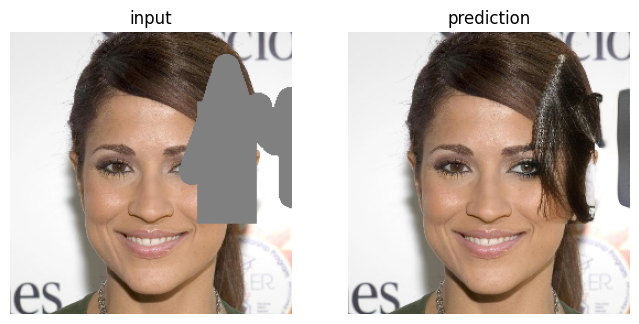

In [7]:
from taming.modules.util import scatter_mask, box_mask, mixed_mask, BatchRandomMask
import time
from skimage.transform import rescale, resize, downscale_local_mean

def get_data(k, res, p=None):
    if p is None:
        p = places_val_files[k]                 
    gt = center_crop(imread(p))
    if len(gt.shape) == 2:
        gt = np.repeat(gt[...,None], 3, axis=2) 
    gt = preprocess(gt, res)
    try:
        mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    except Exception:
        return gt, None
    return gt, mask_in


# examplar: 41, 922

# 4843 (dec), 2421 (dec), 717 (git), 2376 (git), 37 (dec)

# 28 (dec), 34 (git)

# print(batch['filename_'])

def center_crop(image, s=512):
    h, w = image.shape[:2]
    if s > h or s > w:
        image = rescale(image, s/min(h,w), anti_aliasing=True)
        image = (image * 255).astype(np.uint8)
        h, w = image.shape[:2]
    ih = (h - s) // 2   
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

'''
candidate settings : 
1) 0.33 ratio, 0.8 degrad, 1.0t, no topk (more error prone)
2) 0.1 ratio, 0.95 degrad. 1.0t, no topk
3) 0.2 ratio, 0.9 degrad, 1.0t, no topk (default)


'''
def forward_to_indices(model, batch, z_indices, mask):
    x, c = model.get_xc(batch)
    x = x.to(device=device).float()
    c = c.to(device=device).float()
    quant_c, c_indices = model.encode_to_c(c)
    mask = model.preprocess_mask(mask, z_indices)
    r_indices = torch.full_like(z_indices, model.mask_token)
    z_start_indices = mask*z_indices+(1-mask)*r_indices      
    index_sample, probs, candidates = model.sample(z_start_indices.to(device=device), 
                               c_indices.to(device=device),
                               sampling_ratio=0.2,
                               temperature = 1,
                               sample=True,
                               temperature_degradation=0.9,
                               top_k=None,
                               return_probs = True,
                               scheduler = 'cosine',
                              )
    return index_sample, probs, candidates

 
def perturb_shrink(m, k=3):
    # linear blending
    kernel = torch.ones(1,1,k,k) / k**2
    pad = k // 2
    mask2 = F.conv2d(F.pad((m),(pad,pad,pad,pad),value=1), kernel.to(mask.device), bias=None, padding=0)
    mask2 = mask2 > 0
    return mask2.float()

    
# src = '/home/chenh/data/val_large/Places365_val_00010691.jpg'

# clamp ratio
cr = 0.25

use_vanilla = True

with torch.no_grad():
    
    batch = dataset[k]
    input_name = os.path.basename(batch['img_path']).split('.')[0]
    print(batch['img_path'])
    gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
    mask = torch.from_numpy(batch['mask'].transpose(2,0,1)).unsqueeze(0).to(device)
    # gt, mask = get_data(k, 256)
    x = gt.to(device)
    
    #############################
    # mask = box_mask(x.shape, x.device, 0.8, det=True).float()
    # mask = torch.from_numpy(BatchRandomMask(x.shape[0], x.shape[-1], hole_range=[0.0,0.5])).to(x.device)
    #     for i in range(200):
    #         bmask = box_mask(x.shape, x.device, 0.05, det=False).float()
    #         mask = torch.logical_and(mask, bmask).float()
    ##################################
    mask = torch.round(mask).to(device)

    mask_gt = mask
    # mask = perturb_shrink(mask)
    
    VQModel, Encoder, Transformer, Unet = model.helper_model
    VQModel = VQModel.to(device)
    Encoder = Encoder.to(device)
    Transformer = Transformer.to(device)

    gt_quant_z, _, info_gt = VQModel.encode(x)

    start_encoder = time.time()

    if use_vanilla:
        quant_z, _, info = VQModel.encode(x*mask_gt)
        mask_out = F.interpolate(mask, (16,16))
    else:
        quant_z, _, info, mask_out = Encoder.encode(x*mask_gt, mask, clamp_ratio=cr)
        # quant_z, _, info = VQModel.encode(x*mask_gt)

    mask_out = mask_out.reshape(x.shape[0], -1)
    z_indices = info[2].reshape(x.shape[0], -1)

    ### perfect encoder
    # z_indices = info_gt[2].reshape(x.shape[0], -1) * mask_out
    # z_indices = z_indices.int()
    ######################
    
    new_batch = {'image': (x*mask_gt).permute(0,2,3,1)}
    end_encoder = time.time()
    z_indices_complete, probs, candidates = forward_to_indices(Transformer, new_batch, z_indices, mask_out)
    end_transformer = time.time()
    B, C, H, W = quant_z.shape
    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))

    # quant_z_complete = gt_quant_z   
    # mask_out_interpolate = F.interpolate(mask, (16,16)).reshape(x.shape[0], -1)
    # rec, _, _, quant_z, _, _ = model(batch, recomposition=True, mask=mask, simple_return=False)
    # rec_fstg = VQModel.decode(quant_z)

    
    rec_fstg = VQModel.decode(quant_z_complete)
    rec_fstg_comp = x * mask_gt + rec_fstg * (1-mask_gt) 
    
    dec, _, mout, f0, f1 = model.current_model(new_batch, 
                                quant=quant_z_complete, 
                                mask_in=mask, 
                                mask_out=mask_out.reshape(B, 1, H, W),
                                return_fstg=False, debug=True)  

    if use_vanilla:
        dec = rec_fstg
        
    rec = x * mask_gt + dec * (1-mask_gt) 

    if Unet is not None:
        Unet = Unet.to(device)
        rec = Unet.refine(rec, mask)
    end_decoder = time.time()

# t1 = end_encoder-start_encoder
# t2 = end_transformer-end_encoder
# t3 = end_decoder-end_transformer
# print("Encoder Inference speed:", t1,'s')
# print("Transformer Inference speed:", t2,'s')
# print("Decoder Inference speed:", t3,'s')
# print("All:", t1+t2+t3, 's')

mask_int = F.interpolate(F.interpolate(mask, size=(16,16), mode='nearest'),(256,256))
mask_out_int = F.interpolate(mask_out.reshape(1,1,16,16),(256,256))

# imshow([to_img(x*mask), to_img(rec_fstg)])
imshow([to_img(x*mask_gt),to_img(rec)], titles=['input', 'prediction'])

# k = 68

In [41]:
mask_out.shape

torch.Size([1, 1, 16, 16])

In [98]:
# 21756
k = 201

In [8]:

target = "maskgit_celeba_ra"
os.makedirs(f'logs/results/{target}', exist_ok=True)

imsave(f'logs/results/{target}/{input_name}_source.png', to_img(x))
imsave(f'logs/results/{target}/{input_name}_input.png', to_img(x*mask))
imsave(f'logs/results/{target}/{input_name}_rec.png', to_img(rec))

import shutil
shutil.copy(batch['mask_path'], f'logs/results/{target}/{input_name}_mask.png')

'logs/results/maskgit_celeba_ra/077077_mask.png'

In [5]:
#### dataset index search 
for idx, batch in enumerate(dataset.data_list):
    img_path, name = batch
    input_name = os.path.basename(img_path).split('.')[0]
    if input_name ==  f'{77077:06d}': # f'Places365_val_{27948:08d}': # f'{128652:06d}':
        print(idx)
        k = idx
        break

45


In [113]:
# encoder classification 1
k = 201
batch = dataset[k]
input_name = os.path.basename(batch['img_path']).split('.')[0]
gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
mask = torch.from_numpy(batch['mask'].transpose(2,0,1)).unsqueeze(0).to(device)
# mask = box_mask(x.shape, x.device, 0.8, det=True).float()
x = gt.to(device)
mask = torch.round(mask).to(device)
VQModel, Encoder, Transformer, Unet = model.helper_model
VQModel = VQModel.to(device)
Encoder = Encoder.to(device)
Transformer = Transformer.to(device)

gt_quant_z, _, info_gt = VQModel.encode(x)
    
    
quant_z_v, _, info_v = VQModel.encode(x*mask)
quant_z, _, info, mask_out = Encoder.encode(x*mask, mask, clamp_ratio=cr)
acc1 = (info[2] == info_gt[2]).sum() / mask_out.sum()
acc2 = (info_v[2] == info_gt[2]).sum() / mask_out.sum()

print(acc1, acc2)

tensor(0.2428, device='cuda:3') tensor(0.1965, device='cuda:3')


In [ ]:
# encoder classification
k = 43
accs1 = []
accs2 = []
for k in range(3000):
    with torch.no_grad():
        batch = dataset[k]
        input_name = os.path.basename(batch['img_path']).split('.')[0]
        gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
        mask = torch.from_numpy(batch['mask'].transpose(2,0,1)).unsqueeze(0).to(device)
        mask = box_mask(x.shape, x.device, 0.8, det=True).float()
        x = gt.to(device)
    
        mask = torch.round(mask).to(device)
    
        
        VQModel, Encoder, Transformer, Unet = model.helper_model
        VQModel = VQModel.to(device)
        Encoder = Encoder.to(device)
        Transformer = Transformer.to(device)
    
        gt_quant_z, _, info_gt = VQModel.encode(x)
    
        start_encoder = time.time()
    
        quant_z_v, _, info_v = VQModel.encode(x*mask)
        quant_z, _, info, mask_out = Encoder.encode(x*mask, mask, clamp_ratio=cr)
        acc1 = (info[2] == info_gt[2]).sum() / mask_out.sum()
        acc2 = (info_v[2] == info_gt[2]).sum() / mask_out.sum()
        accs1.append(acc1)
        accs2.append(acc2)

In [ ]:
# accs1 = [a.item() for a in accs1]
# accs2 = [a.item() for a in accs2]
print(np.array(accs1).mean())
print(np.array(accs2).mean())

In [ ]:
r = 0.0
mask2 = F.interpolate(mask, (128,128), mode='bilinear') > r
mask2 = mask2.float()
mask2 = F.interpolate(mask2, (64,64), mode='bilinear') > r
mask2 = mask2.float()
mask2 = F.interpolate(mask2, (32,32), mode='bilinear') > r
mask2 = mask2.float()
mask2 = F.interpolate(mask2, (256,256))
imshow([to_img(x*mask),to_img(x*mask2)])
imsave(f'logs/results/{target}/{input_name}_{r}_input.png', to_img(x*mask2))

In [ ]:
imsave(f'logs/results/{target}/{input_name}_rec5.png', to_img(rec))

In [ ]:
# diversity score
use_vanilla = True

with torch.no_grad():
    mask = box_mask(x.shape, x.device, 0.8, det=True).float()
    mask = torch.round(mask).to(device)
    VQModel, Encoder, Transformer, Unet = model.helper_model
    VQModel = VQModel.to(device)
    Encoder = Encoder.to(device)
    Transformer = Transformer.to(device)
    lpips = LPIPS().to(device)
    all_dists = []
    for k in range(1000): 
        batch = dataset[k] 
        gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
        x = gt.to(device)    
        gt_quant_z, _, _ = VQModel.encode(x)
        if use_vanilla:
            quan_z, _, info = VQModel.encode(x*mask)
            mask_out = F.interpolate(mask, (16,16))
        else:
            quant_z, _, info, mask_out = Encoder.encode(x*mask, mask)
        mask_out = mask_out.reshape(x.shape[0], -1)
        z_indices = info[2].reshape(x.shape[0], -1)
        batch = {'image': (x*mask).permute(0,2,3,1)}
        n_sample = 10
        samples = []
        for i in range(n_sample):
            z_indices_complete, probs, candidates = forward_to_indices(Transformer, batch, z_indices, mask_out)
            B, C, H, W = quant_z.shape
            quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))
            if use_vanilla:
                dec = VQModel.decode(quant_z_complete)
            else:
                dec, _, mout, f0, f1 = model.current_model(batch, 
                                            quant=quant_z_complete, 
                                            mask_in=mask, 
                                            mask_out=mask_out.reshape(B, 1, H, W),
                                            return_fstg=False, debug=True)  
            rec = x * mask + dec * (1-mask) 
            
            if Unet is not None and not use_vanilla:
                Unet = Unet.to(device)
                rec = Unet.refine(rec, mask)
    
            samples.append(rec)
    
            all_dists_item = []
            for i, img in enumerate(samples):
                for j, s in enumerate(samples):
                    if i != j:
                        all_dists_item.append(lpips(img, s).item())
        mean = np.array(all_dists_item).mean()
        all_dists.append(mean)

print(np.array(all_dists).mean())
print(np.array(all_dists).std())

In [ ]:
gt, mask = get_data(indices[3], 256)
print(len(indices))
imshow([to_img(gt*mask)])


In [ ]:
with torch.no_grad():
    all_probs = np.concatenate([p.reshape(-1) for p in probs])
    all_cands = np.concatenate([c.reshape(-1) for c in candidates])
    replace = all_cands[np.argsort(all_probs)[100:]]

    z_indices_complete[0,replace] = 0
    mask_out_2 = (z_indices_complete != 0).float()
    
    z_indices_complete, _, _ = forward_to_indices(Transformer, batch, z_indices_complete.int(), mask_out_2)
    B, C, H, W = quant_z.shape
    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))
    rec_fstg = VQModel.decode(quant_z_complete)
    dec, _ = model.current_model(batch, 
                            quant=quant_z_complete, 
                            mask_in=mask,
                            mask_out=mask_out.reshape(B, 1, H, W),
                            return_fstg=False,
                            debug=False)
    
    rec2 = x * mask + dec * (1-mask) 
    imshow([to_img(x*mask), to_img(rec), to_img(rec2)])

In [ ]:
ps = [p.reshape(-1) for p in probs]
cs = [c.reshape(-1) for c in candidates]

canvas = np.zeros([16**2,3])
canvasB = np.zeros([16**2,3])
step = 0
for p, c in zip(ps,cs):
    for p0, c0 in zip(p,c):
        canvas[c0,0] = 1.0
        canvasB[c0,0] = p0
    if step >= end:
        break
    step += 1
        
canvas = (canvas * 255).astype(np.uint8) 
canvas = canvas.reshape(16,16,3)
canvasB = (canvasB * 255).astype(np.uint8) 
canvasB = canvasB.reshape(16,16,3)
end += 1
imshow([canvas, canvasB])

In [ ]:
# imshow([to_img(x*mask),to_img(x*mask_out), to_img(rec_fstg), to_img(rec)])
print(np.unique(mask_int.detach().cpu().numpy()))
imshow([to_img(x*mask), to_img(x*mask_out_int), to_img(x*(mask_int>0.25))])


In [ ]:
with torch.no_grad():
    gt_quant_z, _, _ = VQModel.encode(x)
    m = mask_out.reshape(1,1,16,16)
    quant_compose = (1-m) * gt_quant_z + m * quant_z
    rec_gt = VQModel.decode(gt_quant_z)
    rec_cls = VQModel.decode(quant_compose)

imshow([to_img(rec_gt), to_img(rec_cls)])

In [ ]:
@torch.no_grad()
def predict(gt, mask, m):
    x = gt.to(device)
    mask_in = mask.to(device)
    batch = {'image': gt.permute(0,2,3,1)}
    rec, _ = m(batch, recomposition=False, mask=mask_in, simple_return=True)

    # linear blending
    k = 3
    kernel = torch.ones(1,1,k,k) / k**2
    pad = k // 2
    smoothed_mask = F.conv2d(F.pad(mask_in,(pad,pad,pad,pad),value=1), kernel.to(mask_in.device), bias=None, padding=0)
    smoothed_mask = mask_in
    
    # composition
    rec = smoothed_mask * gt + (1 - smoothed_mask) * rec
    return rec

gt, mask = get_data(4, 256)
rst = predict(gt, mask, model)
imshow([to_img(gt*mask), to_img(rst)], titles=['input','pred'])

In [ ]:
# pyramid blending? doesn't seem to work...
import cv2 as cv

A = to_img(x*mask)
B = to_img(rec)
M = mask[0].permute(1,2,0).detach().cpu().numpy().astype(np.uint8)

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
 G = cv.pyrDown(G)
 gpA.append(G)
    
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
 G = cv.pyrDown(G)
 gpB.append(G)
    
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
 GE = cv.pyrUp(gpA[i])
 L = cv.subtract(gpA[i-1],GE)
 lpA.append(L)
    
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
 GE = cv.pyrUp(gpB[i])
 L = cv.subtract(gpB[i-1],GE)
 lpB.append(L)
    
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
 rows,cols,dpt = la.shape
 currM = cv2.resize(M,la.shape[:2]).astype(np.uint8)[...,None]
 ls = currM * la + (1-currM) * lb
 LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
 ls_ = cv.pyrUp(ls_)
 ls_ = cv.add(ls_, LS[i])

imshow([B, M * A + (1-M) * ls_])